# COMP24111 - Exercise 3: _Face recognition_

## 1. Task description

You will work on a face recognition task. The provided dataset includes face images of 40 subjects. There are a total of 400 images, with 10 images per subject. Each image contains 32×32=1024 pixels, with 256 grey levels per pixel.

## 2. Preparation

### Setting up

The functions that you need are defined in the source file we have provided you with. To use them you must import it first:

In [1]:
from lab3lib import load_data, show_single_face, show_faces, partition_data, split_left_right, join_left_right, show_split_faces

Now you can load the data:

In [2]:
data, labels = load_data()

### Visualising the dataset

You can observe the faces stored in a data matrix by using the functions `show_single_face()` and `show_faces()`.

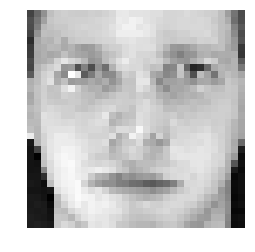

In [3]:
# Display a single example.
show_single_face(data[0, :])

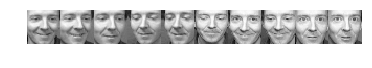

In [4]:
# Display the first 16 examples in a 4x4 grid.
show_faces(data[20:30, :], num_per_row=10)

### Splitting into train and test set

A data partition function is supplied to facilitate your experiments. It randomly splits the provided data into the training and test sets, where the training set contains $N$ samples per class and the test set contains
the remaining samples. It takes the labels and the specified number $N$ as the input. It returns the sample indices in the training and test set. For example, the following code divides a given set of 400 samples into a training set containing 3 samples per subject and a test set containing 7 samples per subject:

In [5]:
tr_ind, te_ind = partition_data(labels, num_per_class=3)
tr_data = data[tr_ind, :]
tr_label = labels[tr_ind]
te_data = data[te_ind, :]
te_label = labels[te_ind]
a = labels[0:15]
tr_ind_e, te_ind_e = partition_data(a, num_per_class=5)
print(labels[1:12])
print(tr_ind_e)
print(tr_data.shape[0])
print(tr_data.shape)


[1 1 1 1 1 1 1 1 1 2 2]
[ 1  4  5  6  7 10 11 12 13 14]
120
(120, 1024)


## 3. $L_2$-regularised least squares implementation

Now, you will need to implement the function `l2_rls_train` below. It should train a linear model by minimising the $L_2$-regularised sum of squares loss using the normal equations (this is called $L_2$*-regularised least squares model*, or *ridge regression model*). It should support both single-output and multi-output cases. This function should take a set of training samples and a user-specified regularisation parameter $\lambda$ as the input, and return the predicted weights.

In [6]:
import numpy as np
def l2_rls_train(tr_data, tr_labels, l2_lembda
                ):
    """
    A summary of your function goes here.

    data: type and description of "data"
    labels: type and description of "labels"

    Returns: type and description of the returned variable(s).
    """
    # This is just to be consistent with the lecture notes.
    X, y = tr_data, tr_labels
    
    # Expand X with a column of ones.
    X_tilde = np.ones([(X.shape[0]), (X.shape[1] + 1)])
    for i in range(X.shape[0]):
        X_tilde[i] = np.append([1], X[i])
    
    # Compute the coefficient vector.
    # When parameter is zero, use pesudo inverse equation
    if len(tr_labels.shape) == 1:
        if l2_lembda != 0:
            identy_matrix = np.eye(X_tilde.shape[0])
            w = ((X_tilde.T)@np.linalg.inv(X_tilde@X_tilde.T + l2_lembda *identy_matrix))@y[:,None]
        else:
            w = np.linalg.pinv(X_tilde)@y[:,None]
    else:
        if l2_lembda != 0:
            identy_matrix = np.eye(X_tilde.shape[0])
            w = ((X_tilde.T)@np.linalg.inv(X_tilde@X_tilde.T + l2_lembda *identy_matrix))@y
        else:
            w = np.linalg.pinv(X_tilde)@y

     #Return model parameters.
    return w


Once you have trained your model, you can use it on to predict new data. Implement the following function to do this.

In [7]:
def l2_rls_predict(w, data
                  ):
    """
    A summary of your function goes here.

    data: type and description of "data"

    Returns: type and description of the returned variable(s).
    """
    
    # This is just to be consistent with the lecture notes.
    X = data
    #expand feature vector
    X_expanded = np.ones([(X.shape[0]), (X.shape[1] + 1)])
    for i in range(X.shape[0]):
        X_expanded[i] = np.append([1], X[i])
    # Your code goes here
    predicted_y = X_expanded@w
    #predicted_y = w.T@X_expanded.T
    
    
    return predicted_y


## 4. Experiments

Start to use your functions `l2_rls_train` and `l2_rls_predict` to perform the following experiments.

### Experiment 1: Binary Classification

Start with a binary classification task to classify face images for subjects “1” and “30”.

Train three classifiers:
1. Set $y=-1$ for samples from “1” and $y=+1$ for samples from “30” to train a linear model, and use the threshold $T= 0$ to obtain the class prediction.
2. Set $y=0$ for samples from “1” and $y=1$ for samples from “30” to train a linear model, and use the threshold $T= 0.5$ to obtain the class prediction.
2. Set $y=1$ for samples from “1” and $y=30$ for samples from “30” to train a linear model, and use the threshold $T= 15.5$ to obtain the class prediction.

Randomly select 3 images per subject for training, and use the remaining images for testing. Train your classifier 1 and test it with a fixed regularisation parameter $\lambda$=0. Repeat this process 50 times and record the training and test errors.

In [8]:
def exp1(label_class_1, label_class_30):
    tr_err = np.zeros([50])
    te_err = np.zeros([50])
    
    for i in range(50):
        # Map the labels and partition the data
        num_per_class = 3
        tr_data = np.zeros([6,data.shape[1]])
        te_data = np.zeros([14,data.shape[1]])
        tr_ind, te_ind = partition_data(labels, num_per_class)
        tr_data[0:3,:] = (data[tr_ind, :])[0:3, :]
        tr_data[3:6,:] = (data[tr_ind, :])[87:90, :]
        te_data[0:7,:] = (data[te_ind, :])[0:7, :]
        te_data[7:14,:] = (data[te_ind, :])[203:210, :]
        tr_label = np.zeros(num_per_class*2, dtype = int)
        tr_label[0:num_per_class]= label_class_1
        tr_label[num_per_class:num_per_class*2]= label_class_30
        # Train your model
        w = l2_rls_train(tr_data, tr_label, 0)
        
        # Define the threshold
        T = (label_class_1+label_class_30)/2

        # Perform prediction for training and compute the training error
        predicted_y_train = l2_rls_predict(w,tr_data)
        predicted_y_test = l2_rls_predict(w,te_data)

        tr_err[i] = ((predicted_y_train[0:3, :] >= T).sum() + (predicted_y_train[3:6, :]<T).sum())/6;

        # Perform prediction for testing and compute the test error
        te_err[i] = ((predicted_y_test[0:7, :] >= T).sum() + (predicted_y_test[7:14, :]<T).sum())/14;
    return tr_err,te_err

In [46]:
# Use the `exp1()` function to experiment with classifier 1.
# Your code goes here.
classification_1_train = exp1(-1,1)[0]
classification_1_test = exp1(-1,1)[1]

Repeat the same experiment for classifier 2.

In [47]:
# Use the `exp1()` function to experiment with classifier 2.
# Your code goes here.
classification_2_train = exp1(0,1)[0]
classification_2_test = exp1(0,1)[1]

Repeat the same experiment for classifier 3.

In [48]:
# Use the `exp1()` function to experiment with classifier 3.
# Your code goes here.
classification_3_train = exp1(1, 30)[0]
classification_3_test = exp1(1,30)[1]

Print the test error mean and standard deviation of the three classifiers and display them in the same plot.

 Classifier   | train/test |  mean      | standard deviation 
 1            | train      |  0.0000000 |  0.0000000
 1            | test       |  0.0671429 |  0.0962671
 2            | train      |  0.0000000 |  0.0000000
 2            | test       |  0.0885714 |  0.1025790
 3            | train      |  0.0000000 |  0.0000000
 3            | test       |  0.0800000 |  0.0910707


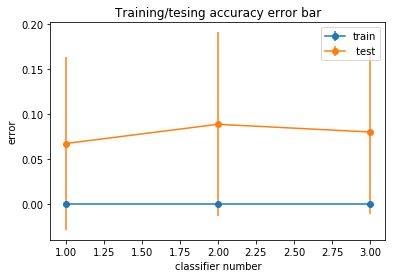

In [49]:
# Your code goes here
print(' Classifier   | train/test |  mean      | standard deviation ')
print('% 2d            | train      | % 10.7f | % 10.7f'%(1, classification_1_train.mean(),classification_1_train.std()))
print('% 2d            | test       | % 10.7f | % 10.7f'%(1, classification_1_test.mean(),classification_1_test.std()))
print('% 2d            | train      | % 10.7f | % 10.7f'%(2, classification_2_train.mean(),classification_2_train.std()))
print('% 2d            | test       | % 10.7f | % 10.7f'%(2, classification_2_test.mean(),classification_2_test.std()))
print('% 2d            | train      | % 10.7f | % 10.7f'%(3, classification_3_train.mean(),classification_3_train.std()))
print('% 2d            | test       | % 10.7f | % 10.7f'%(3, classification_3_test.mean(),classification_3_test.std()))


from matplotlib import pyplot as plt
x = [1,2,3]
y_train_error = [classification_1_train.mean(), classification_2_train.mean(), classification_3_train.mean()]
train_std = [classification_1_train.std(), classification_2_train.std(), classification_3_train.std()]
y_test_error = [classification_1_test.mean(), classification_2_test.mean(), classification_3_test.mean()]
test_std = [classification_1_test.std(), classification_2_test.std(), classification_3_test.std()]
plt.errorbar(x, y_train_error, train_std,marker = "o",label='train')
plt.errorbar(x, y_test_error, test_std,marker = "o",label=' test')
plt.xlabel('classifier number')
plt.ylabel('error')
plt.title('Training/tesing accuracy error bar')
plt.legend()
plt.show()

Compare the three classifiers and comment on your results.

What training accuracies do you obtain with your linear classifier? Explain the reason.

Between subjects “1” and “30”, which one is more difficult for the linear classifier to recognise? Explain it.

### Experiment 2: Multi-class Classification

Now, proceed to the multi-class classification task to classify face images for all the 40 subjects. Decide an appropriate way to set your target output and make class prediction. 

Split your data to two sets: the training set contains 5 randomly selected images per subject and the test set contains the remaining images. The training set is used to train the model and select hyper-parameter $\lambda$, while the test set is only for final assessment of the trained classifier with the selected $\lambda$. 

Design an appropriate and complete machine learning experiment, which should include the training, hyper-parameter selection and evaluation stages. You can choose from the random subsampling, $k$-fold CV and LOO approaches for hyper-parameter selection. 

Write your code below and make sure it compiles. Show your code to the TA, explain your classifier and experiment design.

In [13]:
def hyperparameter_selection(hyperparameter_set, train_ind
                            ):
    """
    Finds the best value for lambda using some method of hyperparameter selection.
    """
    lamda_error_rate = np.empty(hyperparameter_set.shape[0]) #record the error rate under each parameter
    # Your code goes here
    no_lambda = 0
    for no_lambda in range(hyperparameter_set.shape[0]):
        lambda_ = hyperparameter_set[no_lambda]
        #choose LOO function, N is 5.
        number_of_selection = 4
        eror_per_N = np.empty(5)
        for k in range(5):        
            #given 4 tarining data 1 test data to find least lambda
            lambda_train_ind = np.zeros(number_of_selection * 40,dtype = int) 
            lambda_test_ind = np.zeros((5-number_of_selection) * 40,dtype = int)
            temp = 0
            tr_temp = 0
            te_temp = 0
            for i in range(40):
                lambda_test_ind[te_temp: te_temp+1] = (train_ind[temp:temp+5])[k]
                lambda_train_ind[tr_temp: tr_temp+4] = np.setdiff1d(train_ind[temp:temp+5], lambda_test_ind[te_temp: te_temp+1])
                tr_temp += 4
                te_temp += 1
                temp += 5
            #after LOO the train data.
            lambda_train_label = np.zeros([number_of_selection * 40, 40], dtype = int)
            lambda_train_data = data[lambda_train_ind, :]
            lambda_test_data = data[lambda_test_ind,:]
            lambda_test_label = labels[lambda_test_ind]
            #start to transform the label matrix
            for x in range(40):
                for r in range(number_of_selection * 40):
                    if(r >= x*number_of_selection and r< (x+1)*number_of_selection):
                        for c in range(40):
                            if c == x: 
                                lambda_train_label[r,c] = 1
                            else:
                                lambda_train_label[r,c] = -1
            #then check weight 
            w = l2_rls_train(lambda_train_data, lambda_train_label, lambda_)
            predicted_y_test = l2_rls_predict(w,lambda_test_data)
            #analysis error rate 
            predict_result = np.argmax(predicted_y_test,axis=1)+1
            eror_per_N[k] = (40-np.sum(predict_result == lambda_test_label))/40
            
        #after all 5 LOO, find the mean error rate and refers to the specific lambda
        lamda_error_rate[no_lambda] = eror_per_N.mean()
    
    #find the best lambda
    best_lambda = np.argmin(lamda_error_rate)
        
        
    return lamda_error_rate, hyperparameter_set[best_lambda]

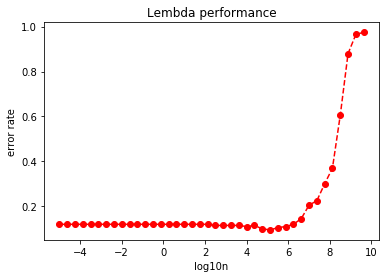

Evaluation error rate is 0.03
object: 1 with: 1
object: 3 with: 1
object: 5 with: 1
object: 10 with: 1
object: 13 with: 1
object: 26 with: 1


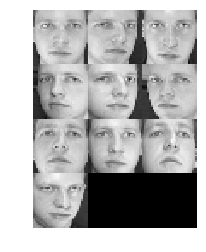

In [14]:
# Your code goes here
tr_ind, te_ind = partition_data(labels, num_per_class=5)
tr_data = data[tr_ind, :]
tr_label = labels[tr_ind]
te_data = data[te_ind, :]
te_label = labels[te_ind]
#give set of lambdas 
base_set = np.arange(start=-5, stop=10, step=0.375)
hyper_set = np.zeros(40)
for i in range(hyper_set.shape[0]):
    hyper_set[i] = 10**base_set[i]
#train the data and find the best lambda
result = hyperparameter_selection(hyper_set,tr_ind)
error_rate = result[0]
best_lembda = result[1]

#plot the all lemda performance
x = base_set
y_train_error = error_rate
plt.plot(base_set, error_rate,'r--o')
plt.xlabel('log10n')
plt.ylabel('error rate')
plt.title('Lembda performance')
plt.show()

#use the best lemda to train test data
lambda_train_label = np.zeros([200, 40], dtype = int)
for x in range(40):
        for r in range(5 * 40):
            if(r >= x*5 and r< (x+1)*5):
                for c in range(40):
                    if c == x: 
                        lambda_train_label[r,c] = 1
                    else:
                        lambda_train_label[r,c] = -1
w = l2_rls_train(tr_data, lambda_train_label, best_lembda)
predicted_y_test = l2_rls_predict(w,te_data)
predict_result = np.argmax(predicted_y_test,axis=1)+1
test_eror_rate = (200-np.sum(predict_result == te_label))/200

#find which subject is most difficult to recognise
difference = (predict_result !=te_label)
error_object = np.empty(40, dtype = int )
print('Evaluation error rate is',test_eror_rate)
for i in range(1,41):
    error_object[i-1] = np.sum(difference[(i-1)*5 :(i-1)*5 +5 ])
for i in range(40):
    if(error_object[i] != 0):
        print("object:", i+1, "with:", error_object[i])
max = np.argmax(error_object)
show_faces(data[max*10:(max*10 + 10), :], num_per_row=3)

Analyse the classification results, and pick some subjects that are considered the most difficult to recognise by your classifier. Show and explain it to the TA.

### Experiment 3: Face Completion

Revise the “Regression Example II” on face completion in Chapter 2. The task is to guess the 512 pixels of the right face from the 512 pixels of the left face. 

The following command can be used to extract the left and right faces from the input data.

In [15]:
left, right = split_left_right(data)

And you can visualise them with the function `show_split_faces()`:

In [16]:
print(left)

[[ 75 101 128 ... 166 164 157]
 [110 124 144 ... 156 157 151]
 [ 77 119 142 ... 172 165 159]
 ...
 [121 147 159 ... 150 154 152]
 [ 52  53  51 ... 183 188 191]
 [125  68  60 ... 178 184 180]]


Build a face completion model using your functions `l2_rls_train` and `l2_rls_predict`. Design an experiment to assess your model, which should include appropriate training and testing. Use mean absolute percentage error to evaluate the regression performance. You do not need to bother with hyper-parameter selection, but simply set $\lambda$=0.

Write your code below and make sure it compiles. Show your code to the TA, explain your model and experiment design, and demonstrate results.

In [17]:
# Your code goes here
def face_completion(tr_data_3_left, tr_data_3_right, te_data_3_left, te_data_3_right):
    #train the model by finding the relation between right face and left face.
    w_3 = l2_rls_train(tr_data_3_left, tr_data_3_right, 0)
    predicted_y_test = l2_rls_predict(w_3,te_data_3_left)
    MAPE_N = np.empty((10-number_of_train)*40)
    for i in range((10-number_of_train)*40):
        MAPE_M = np.empty(512) 
        for j in range(512):
            MAPE_M[j] = abs(te_data_3_right[i, j]- predicted_y_test[i,j])/te_data_3_right[i,j]
        MAPE_N[i] = MAPE_M.sum()
    #follow the MAPE formula to get the final error rate 
    error_rate = MAPE_N.sum()/((10-number_of_train)*40*512)
    return error_rate, predicted_y_test


Visualise and compare the ground truth face (include both the left and right parts) and the completed face (include both the true left and predicted right parts) for 3 randomly chosen testing samples below. You can use `join_left_right(left, right)` to concatenate the left and right halves of a set of faces.

Error rate for face completion mode is  0.2381766720427607


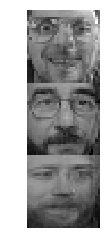

In [18]:
# Your code goes here
import random
number_of_train = 5
left, right = split_left_right(data)
tr_ind_3, te_ind_3 = partition_data(labels, num_per_class= number_of_train)
tr_data_3_left = left[tr_ind_3, :]
tr_data_3_right = right[tr_ind_3, :]
te_data_3_left = left[te_ind_3, :]
te_data_3_right = right[te_ind_3]
#random choose three examples from the test data
c = range(0,(10-number_of_train)*40)
random_face = random.sample(c, 3)
left_face = te_data_3_left[random_face, :]
#predict the right faces of test data set
result = face_completion(tr_data_3_left, tr_data_3_right, te_data_3_left, te_data_3_right)
right_face = (result[1])[random_face, :]
face= join_left_right(left_face,right_face)
show_faces(face,num_per_row=1)
print("Error rate for face completion mode is ", result[0])

Does your model work well? Comment on it.

## 5. Deliverables and Marking

By the deadline, you should submit one single Jupyter file using GitLab. Please find the coursework submission instruction from the following link: https://wiki.cs.manchester.ac.uk/index.php/UGHandbook19:Coursework .

This exercise is worth 15 marks – marks will be allocated roughly on the basis of: 
- rigorous experimentation,
- knowledge displayed when talking to the TA,
- problem solving skill,
- self-learning ability,
- how informative and well presented your graphs are,
- language and ease of reading.

You must be able to explain any code you've written in order to get full marks. During the marking session we will ask you to run all cells in your Jupyter file, so ensure that the file is runnable using the "Restart Kernel and Run All Cells" menu option.

The lab is marked out of 15:

|                          |         |
|:------------------------ |--------:|
| $L_2$-RLS Implementation | 3 marks |
| Experiment 1             | 4 marks |
| Experiment 2             | 4 marks |
| Experiment 3             | 4 marks |